# Introduction #

So far in this course, we've learned about how neural networks can solve regression problems. Now we're going to apply neural networks to another common machine learning problem: classification. Most everything we've learned up until now still applies. The main difference is in the loss function we use and in what kind of outputs we want the final layer to produce.

# Binary Classification #

Classification into one of two classes is a common machine learning problem. You might want to predict whether or not a customer is likely to make a purchase, whether or not a credit card transaction was fraudulent, whether deep space signals show evidence of a new planet, or a medical test evidence of a disease. These are all **binary classification** problems.

In your raw data, the classes might be represented by strings like `"Yes"` and `"No"`, or `"Dog"` and `"Cat"`. Before using this data we'll assign a **class label**: one class will be `0` and the other will be `1`. Assigning numeric labels puts the data in a form a neural network can use.

# Accuracy and Cross-Entropy #

**Accuracy** is one of the many metrics in use for measuring success on a classification problem. Accuracy is the ratio of correct predictions to total predictions: `accuracy = number_correct / total`. A model that always predicted correctly would have an accuracy score of `1.0`. All else being equal, accuracy is a reasonable metric to use whenever the classes in the dataset occur with about the same frequency.

The problem with accuracy (and most other classification metrics) is that it can't be used as a loss function. SGD needs a loss function that changes smoothly, but accuracy, being a ratio of counts, changes in "jumps". So, we have to choose a substitute to act as the loss function. This substitute is the *cross-entropy* function.

Now, recall that the loss function defines the *objective* of the network during training. With regression, our goal was to minimize the distance between the expected outcome and the predicted outcome. We chose MAE to measure this distance.

For classification, what we want instead is a distance between *probabilities*, and this is what cross-entropy provides. **Cross-entropy** is a sort of measure for the distance from one probability distribution to another.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/DwVV9bR.png" width="400" alt="Graphs of accuracy and cross-entropy.">
<figcaption style="textalign: center; font-style: italic"><center>Cross-entropy penalizes incorrect probability predictions.</center></figcaption>
</figure>

The idea is that we want our network to predict the correct class with probability `1.0`. The further away the predicted probability is from `1.0`, the greater will be the cross-entropy loss.

The technical reasons we use cross-entropy are a bit subtle, but the main thing to take away from this section is just this: use cross-entropy for a classification loss; other metrics you might care about (like accuracy) will tend to improve along with it.

# Making Probabilities with the Sigmoid Function #

The cross-entropy and accuracy functions both require probabilities as inputs, meaning, numbers from 0 to 1. To covert the real-valued outputs produced by a dense layer into probabilities, we attach a new kind of activation function, the **sigmoid activation**.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/FYbRvJo.png" width="400" alt="The sigmoid graph is an 'S' shape with horizontal asymptotes at 0 to the left and 1 to the right. ">
<figcaption style="textalign: center; font-style: italic"><center>The sigmoid function maps real numbers into the interval $[0, 1]$.</center></figcaption>
</figure>

To get the final class prediction, we define a *threshold* probability. Typically this will be 0.5, so that rounding will give us the correct class: below 0.5 means the class with label 0 and 0.5 or above means the class with label 1. A 0.5 threshold is what Keras uses by default with its [accuracy metric](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy).

# Example - Binary Classification #

Now let's try it out!

The [Ionosphere](https://archive.ics.uci.edu/ml/datasets/Ionosphere) dataset contains features obtained from radar signals focused on the ionosphere layer of the Earth's atmosphere. The task is to determine whether the signal shows the presence of some object, or just empty air.

In [1]:

import pandas as pd
from IPython.display import display

ion = pd.read_csv('../input/dl-course-data/ion.csv', index_col=0)
display(ion.head())

df = ion.copy()
df['Class'] = df['Class'].map({'good': 0, 'bad': 1})

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True) # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('Class', axis=1)
X_valid = df_valid.drop('Class', axis=1)
y_train = df_train['Class']
y_valid = df_valid['Class']

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


We'll define our model just like we did for the regression tasks, with one exception. In the final layer include a `'sigmoid'` activation so that the model will produce class probabilities.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[33]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

Add the cross-entropy loss and accuracy metric to the model with its `compile` method. For two-class problems, be sure to use `'binary'` versions. (Problems with more classes will be slightly different.) The Adam optimizer works great for classification too, so we'll stick with it.

In [3]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

The model in this particular problem can take quite a few epochs to complete training, so we'll include an early stopping callback for convenience.

In [4]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

We'll take a look at the learning curves as always, and also inspect the best values for the loss and accuracy we got on the validation set. (Remember that early stopping will restore the weights to those that got these values.)

Best Validation Loss: 0.6846
Best Validation Accuracy: 0.7429


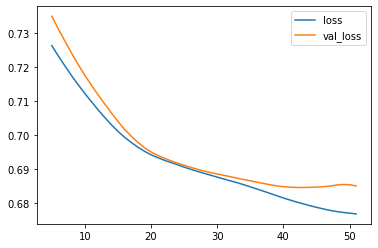

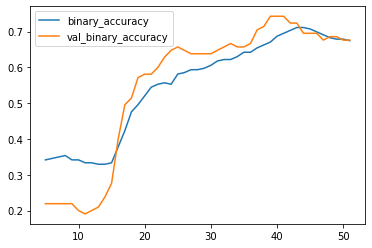

In [5]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

# Your Turn #

Use a neural network to [**predict cancellations in hotel reservations**](https://www.kaggle.com/kernels/fork/11887335) with the *Hotel Cancellations* dataset.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/191966) to chat with other Learners.*